In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

%matplotlib inline

warnings.filterwarnings('ignore')

In [8]:
import wikipedia
monalisa = wikipedia.page('Mona Lisa')
#pyth = wikipedia.page('Python Programming Language')
covid = wikipedia.page('Covid-19 Pandemic')
ds = wikipedia.page('Data Science')

In [9]:
corpus = [monalisa.content,covid.content,ds.content]

### Processing Text - Remove Special Characters, #Sign, Punctuation and change it to lowercase.

In [10]:
def remove_pattern(input_text,pattern):
    r = re.findall(pattern,input_text)
    for word in r:
        input_text = re.sub(word,"",input_text)
    return input_text

def l_case():
    for x in df['clean_tweet']:
        x.lowercase()
        
def remove_breakline(input_text,pattern):
    r = re.findall(pattern,input_text)
    for word in r:
        input_text = re.sub(word,"",input_text)
    return input_text

In [11]:
import re
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(document):
    document = re.sub(r'\W',' ',str(document))
    document = re.sub(r'\s+[a-zA-Z]\s+',' ',document)
    document = re.sub(r'\^[a-zA-Z]\s+',' ',document)
    document = re.sub(r'\s+',' ',document, flags=re.I)
    document = re.sub(r'^b\s+','',document)
    document = document.lower()
    
    tokens = document.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    return tokens
    
processed_data = []
for doc in corpus:
    tokens = preprocess_text(doc)
    processed_data.append(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A0778513\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Subjectivity & Polarity Score

In [12]:
from textblob import TextBlob
# Create a function to get the subjectivity
def getSubjectivity(text):
    print ('Subjectivity of this sentence is',TextBlob(text).sentiment.subjectivity)

# Create a function to get the polarity
def getPolarity(text):
    print ('Polarity Score of this sentence is',TextBlob(text).sentiment.polarity)


getSubjectivity(corpus[0])
getPolarity(corpus[0])

Subjectivity of this sentence is 0.37982076941426535
Polarity Score of this sentence is 0.09526920384643968


### List of Positive & Negative Words

In [15]:
#List of Tokenized Words
#Tokenize words
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
#tw = word_tokenize(corpus,"english")
Posivite_wrds = []
Negative_wrds = []
Neutral_wrds =  []
sv = SentimentIntensityAnalyzer()
for word in processed_data[0]:
    score = sv.polarity_scores(word)
    neg = score['neg']
    pos = score['pos']
    if pos>neg:
        Posivite_wrds.append(word)
    elif neg > pos:
        Negative_wrds.append(word)
    else:
        Neutral_wrds.append(word)

print(Posivite_wrds[:5])
print(Negative_wrds[:5])
print(Neutral_wrds[:5])

['masterpiece', 'ha', 'best', 'novel', 'valuable']
['death', 'death', 'unfortunately', 'argued', 'missing']
['mona', 'lisa', 'italian', 'monna', 'lisa']


In [16]:
def sentiment_analyses(sentiment_text):
    score = SentimentIntensityAnalyzer().polarity_scores(sentiment_text)
    neg = score['neg']
    pos = score['pos']
    if neg>pos:
        return 'negative'
    elif pos > neg:
        return 'positive'
    else:
        return 'neutral'

In [17]:
a = sentiment_analyses(corpus[0])
print(f'It is a {a} statement.')

It is a positive statement.


### Topic Modeling 

In [18]:
import numpy
from gensim import corpora
import gensim
#Tokenize words
from nltk import word_tokenize
# newsent = [[x] for x in sentences]
# tokenize_words = [word_tokenize(sentences[0],"english")]


input_dict = corpora.Dictionary(processed_data)
doc_term_matrix = [input_dict.doc2bow(token,allow_update = True) for token in processed_data]
# input_corpus = (input_dict.doc2bow(token,allow_update=True) for token in tokenize_words)

In [19]:
lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix,num_topics=3,id2word=input_dict,passes=20,chunksize=1000,update_every=1)

In [20]:
lda_model.print_topics(num_words=9)

[(0,
  '0.022*"painting" + 0.021*"wa" + 0.019*"lisa" + 0.018*"mona" + 0.011*"leonardo" + 0.007*"ha" + 0.006*"louvre" + 0.006*"portrait" + 0.005*"work"'),
 (1,
  '0.013*"19" + 0.013*"2020" + 0.012*"covid" + 0.011*"case" + 0.010*"wa" + 0.008*"country" + 0.007*"reported" + 0.007*"pandemic" + 0.006*"people"'),
 (2,
  '0.037*"data" + 0.021*"science" + 0.010*"statistic" + 0.005*"used" + 0.004*"field" + 0.004*"technique" + 0.003*"new" + 0.003*"learning" + 0.003*"name"')]

### LDA Model Accuracy

In [21]:
print('Perplexity', lda_model.log_perplexity(doc_term_matrix,total_docs = 3))

from gensim.models.coherencemodel import CoherenceModel
coherencemodel_lda = CoherenceModel(model=lda_model,texts=processed_data,dictionary = input_dict,coherence='c_v' )
coherence_lda = coherencemodel_lda.get_coherence()
print('Coherence',coherence_lda)

Perplexity -7.529152206871532
Coherence 0.6994024521324717


In [23]:
def compute_coherence_val(doc_term_matrix,texts,dictionary,start,end):
    model_list = []
    coherence_values = []
    for i in range(start,end):
        model_ = gensim.models.ldamodel.LdaModel(doc_term_matrix,num_topics=i,id2word=dictionary,passes=20,chunksize=1000,update_every=1)
        coherencemodel_lda = CoherenceModel(model=model_,texts=texts,dictionary = dictionary,coherence='c_v' )
        coherence_lda = coherencemodel_lda.get_coherence()
        model_list.append(i)
        coherence_values.append(coherence_lda)
    return model_list, coherence_values

In [24]:
top,coh = compute_coherence_val(doc_term_matrix,processed_data,input_dict,2,11)

In [27]:
top

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [28]:
coh

[0.5493281579137967,
 0.6986040113311945,
 0.6656892764302138,
 0.5799545741073748,
 0.5271676874998517,
 0.5014236870545823,
 0.49256353793110597,
 0.47782090406099365,
 0.47863467809872545]

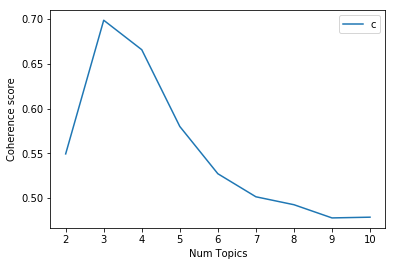

In [30]:
#Show graph
limit=11; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coh)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [31]:
# Print the coherence scores
for m, cv in zip(x, coh):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5493
Num Topics = 3  has Coherence Value of 0.6986
Num Topics = 4  has Coherence Value of 0.6657
Num Topics = 5  has Coherence Value of 0.58
Num Topics = 6  has Coherence Value of 0.5272
Num Topics = 7  has Coherence Value of 0.5014
Num Topics = 8  has Coherence Value of 0.4926
Num Topics = 9  has Coherence Value of 0.4778
Num Topics = 10  has Coherence Value of 0.4786


### Visualizing LDA Model

In [32]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


vis = gensimvis.prepare(lda_model, doc_term_matrix, input_dict)
vis

C:\Users\A0778513\anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.144127 -0.040490       1        1  68.833327
0      0.124170 -0.063751       2        1  25.312272
2      0.019956  0.104242       3        1   5.854401, topic_info=            Term        Freq       Total Category  logprob  loglift
2068        data   38.000000   38.000000  Default  30.0000  30.0000
976     painting   68.000000   68.000000  Default  29.0000  29.0000
800         lisa   58.000000   58.000000  Default  28.0000  28.0000
892         mona   54.000000   54.000000  Default  27.0000  27.0000
1444          wa  150.000000  150.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
3393        term    1.210023    6.959608   Topic3  -6.3844   1.0885
1389  university    1.209951    9.806343   Topic3  -6.3845   0.7455
2476      impact    1.209905    8.701286   Topic3  -6.3845   0.8650
3046       range    1.209801    6.959942   Topic3  -6.3846   1.0883
416    described    1.209312    6.165072   Topic3  -6.3850   1.2091

[181 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1508      1  0.999040       0
0         1  0.965221     000
0         2  0.040218     000
2         1  0.953050       1
2         2  0.028031       1
...     ...       ...     ...
1483      1  0.786887   world
1483      2  0.189938   world
3764      3  0.727814  writes
3765      3  0.727816      wu
3567      1  0.989086   wuhan

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])